In [ ]:
import os
from glob import glob
#import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch, gc
import torch
import torch.nn as nn
from torch.nn.functional import relu, sigmoid
from datetime import datetime

# Load data and preprocess

In [2]:
# Create Dataframe
def create_df(data_dir):
    images_paths = []
    masks_paths = glob(f'{data_dir}/*/*_mask*')
    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))
    df = pd.DataFrame(data= {'images': images_paths, 'masks': masks_paths})
    return df

data_dir = './data/kaggle_3m'
df = create_df(data_dir)
df.head()

,images,masks
0,./data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS...,./data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS...
1,./data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS...,./data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS...
2,./data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS...,./data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS...
3,./data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS...,./data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS...
4,./data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS...,./data/kaggle_3m\TCGA_CS_4941_19960909\TCGA_CS...


In [3]:
# # Function to display images and masks
# def show_images(images, masks):
#     plt.figure(figsize=(12, 12))
#     for i in range(25):
#         plt.subplot(5, 5, i + 1)

#         img_path = images[i]
#         mask_path = masks[i]

#         # Read and convert image to RGB
#         image = cv.imread(img_path)
#         image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

#         # Read the mask
#         mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE) 

#         # Display the image
#         plt.imshow(image)
#         plt.imshow(mask, cmap="jet", alpha=0.4) 
#         plt.axis("off")

#     plt.tight_layout()
#     plt.show()

# show_images(list(df["images"]), list(df["masks"]))

In [4]:
class MaskBinarize:
    def __call__(self, msk):
        msk = (msk > 0.5).float()  
        return msk
    
def img_to_tensor(df, mask=False):#, image_size=(224, 224)):
    if mask:
        transform = transforms.Compose([
            #transforms.Resize(image_size),  
            transforms.ToTensor(),          
            MaskBinarize()
        ])
    else:
        transform = transforms.Compose([
            #transforms.Resize(image_size),  
            transforms.ToTensor(),          
            #MaskBinarize()
        ])
    
    image_tensors = []
    
    for img_path in df:
        try:
            if mask:
                img = Image.open(img_path).convert("L")  # grayscale transform
                img_tensor = transform(img)  # to tensor
                image_tensors.append(img_tensor)
            else:
                img = Image.open(img_path).convert("RGB")  # RGB transform
                img_tensor = transform(img)  # to tensor
                image_tensors.append(img_tensor)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

    if image_tensors:
        # (batch, C, H, W)
        image_tensors = torch.stack(image_tensors)
        print(f"Loaded {len(image_tensors)} images successfully.")
        return image_tensors
    else:
        print("No valid images were loaded.")
        return None

image_tensors = img_to_tensor(df["images"])
mask_tensors = img_to_tensor(df["masks"], mask=True)

if image_tensors is not None:
    print(f"Final tensor shape: {image_tensors.shape}")  # (N, C, H, W)


Loaded 3929 images successfully.
Loaded 3929 images successfully.
Final tensor shape: torch.Size([3929, 3, 256, 256])


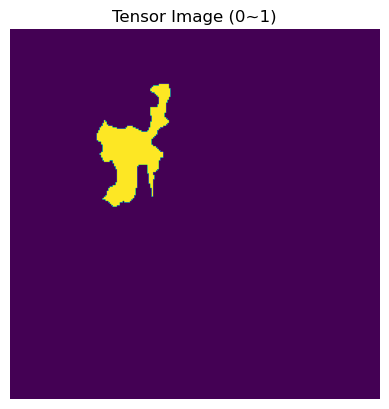

In [5]:
np_img = mask_tensors[6].permute(1, 2, 0).numpy()  # shape: [H, W, 3]

# print test
plt.imshow(np_img)
plt.axis('off')
plt.title("Tensor Image (0~1)")
plt.show()

In [6]:
# data split: 80/10/10
train_img, test_img, train_mask, test_mask = train_test_split(image_tensors, mask_tensors, test_size = 0.1)
train_img, val_img, train_mask, val_mask = train_test_split(train_img, train_mask, test_size = 0.1)

In [7]:
train_dataset = TensorDataset(train_img, train_mask)
val_dataset = TensorDataset(val_img, val_mask)
test_dataset = TensorDataset(test_img, test_mask)

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# Model design

In this section, we will design a UNet architecture to show the usage of this data for image segmentation predictive modeling. Here we can see the process of designing a model architecture using Pytorch, along with a custom loss function that will result in optimal performance for this model. Finally, we will train the model over 200 epochs using patience, a concept that we will elaborate on below.

First, let's define some hyperparameters for the models architecture and training. These hyperparameters are tuned to obtain optimal performance. Try changing some values and see how the model's performance changes.
Let's take a closer look at some of these hyperparameters:
- Kernel Size - This is how big the "sliding window" of the UNet's convolution layers is. A size of 3 will result in a 3x3xc kernel that takes a weighted average of the corresponding pixel values.
- Stride - This is how large the step-size of the kernel is. A stride of 1 means the kernel will move 1 pixel at a time left-to-right and top-to-bottom.
- Padding - This is how many pixels we will zero-pad the image with. Having padding allows us to avoid losing information at the boundaries and control image dimensionality shrinkage during convolution.
- Number of Epochs - This will control the maximum number of training iterations (over ALL training data) will be completed to find the best possible model parameters.
- Patience - This allows us to perform early-stopping if the model fails to improve over a specified number of epochs. 

In [ ]:
folder_path = './models'

kernel_size = 3
# The stride is ho
stride = 1
padding = 1

num_epochs = 1
patience = 5

bce_weight = 0.5 # Coefficient for Binary Cross Entropy loss in loss function

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Model Architecture

Now, we will construct the model. Let's take a closer look at how a UNet works.

A UNet is an image segmentation framework that makes predictions in a two step Encoding-Decoding process.

At each encoding step, the tensor will be downsampled and the number of channels will increased. This is done by using two convolution layers followed by a max-pooling layer.
Max-pooling is a process that downscales a 2D tensor by taking the maximum value within a 2x2 window as the representative value for that group.

Next, the tensor will be upsampled in an inverted process to encoding through several steps of decoding. Each docoder step starts by using transposed convolution followed by two convolution layers. The number of channels gradually decreases as the image reverts to it's original shape. 

To complete a forward pass during training, the Encoder-Decoder steps must be combined in a way that preserves the information of the original image. To do this, we concatonate the the encoder outputs to their corresponfding decoder counterparts after transposed convolution occurs. 

Through this process, a final output image is produced as the predicted mask for the MRI brain scan. A sigmoid activation is applied to this output to ensure each predicted pixel value is between 0-1, making binary classification simple.

In [ ]:
class UNet(nn.Module):
    def __init__(self, kernel_size, stride, padding):
        super().__init__()

        # Encoder - Downsample input images using max-pooling (256x256x3 images)
        self.e11 = nn.Conv2d(3, 32, kernel_size=kernel_size, stride=stride, padding=padding)
        self.e12 = nn.Conv2d(32, 32, kernel_size=kernel_size, stride=stride, padding=padding)
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e21 = nn.Conv2d(32, 64, kernel_size=kernel_size, stride=stride, padding=padding)
        self.e22 = nn.Conv2d(64, 64, kernel_size=kernel_size, stride=stride, padding=padding)
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e31 = nn.Conv2d(64, 128, kernel_size=kernel_size, stride=stride, padding=padding)
        self.e32 = nn.Conv2d(128, 128, kernel_size=kernel_size, stride=stride, padding=padding)
        self.maxpool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e41 = nn.Conv2d(128, 256, kernel_size=kernel_size, stride=stride, padding=padding)
        self.e42 = nn.Conv2d(256, 256, kernel_size=kernel_size, stride=stride, padding=padding)
        self.maxpool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e51 = nn.Conv2d(256, 512, kernel_size=kernel_size, stride=stride, padding=padding)
        self.e52 = nn.Conv2d(512, 512, kernel_size=kernel_size, stride=stride, padding=padding)


        # Decoder - Upsampling using transposed convolution
        self.upconv1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(512, 256, kernel_size=kernel_size, stride=stride, padding=padding)
        self.d12 = nn.Conv2d(256, 256, kernel_size=kernel_size, stride=stride, padding=padding)

        self.upconv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(256, 128, kernel_size=kernel_size, stride=stride, padding=padding)
        self.d22 = nn.Conv2d(128, 128, kernel_size=kernel_size, stride=stride, padding=padding)

        self.upconv3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(128, 64, kernel_size=kernel_size, stride=stride, padding=padding)
        self.d32 = nn.Conv2d(64, 64, kernel_size=kernel_size, stride=stride, padding=padding)

        self.upconv4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(64, 32, kernel_size=kernel_size, stride=stride, padding=padding)
        self.d42 = nn.Conv2d(32, 32, kernel_size=kernel_size, stride=stride, padding=padding)


        # Output
        self.output = nn.Conv2d(32, 1, kernel_size=1)


    # Input processing through the model
    def forward(self, x):
        # Encoder
        e11 = relu(self.e11(x))
        e12 = relu(self.e12(e11))
        maxpool1 = self.maxpool1(e12)

        e21 = relu(self.e21(maxpool1))
        e22 = relu(self.e22(e21))
        maxpool2 = self.maxpool2(e22)

        e31 = relu(self.e31(maxpool2))
        e32 = relu(self.e32(e31))
        maxpool3 = self.maxpool3(e32)

        e41 = relu(self.e41(maxpool3))
        e42 = relu(self.e42(e41))
        maxpool4 = self.maxpool4(e42)

        e51 = relu(self.e51(maxpool4))
        e52 = relu(self.e52(e51))

        #Decoder
        upconv1 = self.upconv1(e52)
        upconv1 = torch.cat([upconv1, e42], dim=1)
        d11 = self.d11(upconv1)
        d12 = self.d12(d11)

        upconv2 = self.upconv2(e42)
        upconv2 = torch.cat([upconv2, e32], dim=1)
        d21 = self.d21(upconv2)
        d22 = self.d22(d21)

        upconv3 = self.upconv3(d22)
        upconv3 = torch.cat([upconv3, e22], dim=1)
        d31 = self.d31(upconv3)
        d32 = self.d32(d31)

        upconv4 = self.upconv4(d32)
        upconv4 = torch.cat([upconv4, e12], dim=1)
        d41 = self.d41(upconv4)
        d42 = self.d42(d41)

        out = self.output(d42)
        out = sigmoid(out)

        return out

### Loss Function

Binary Cross Entropy Loss is a common loss function used for binary classification. In the case of the MRI brain scan image dataset, BCE loss is allows us to train the model for predicting individual pixels as 0 or 1, penalizing incorrect predictions.

Although BCE loss is useful, it does have limitations for this dataset, especially considering class imbalances with most pixels being 0 (no tumor) in these images. To account for this, we will design a custom loss function that incorperates Dice Loss

In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, pred, true):
        pred = pred.view(-1)
        true = true.view(-1)
        intersection = (pred*true).sum()
        dice = (2*intersection + self.smooth) / (pred.sum() + true.sum() + self.smooth)
        return 1 - dice

class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.5):
        super().__init__()
        self.bce = nn.BCELoss()
        self.dice = DiceLoss()
        self.bce_weight = bce_weight

    def forward(self, pred, true):
        bce_loss = self.bce(pred, true)
        dice_loss = self.dice(pred, true)
        return self.bce_weight * bce_loss + (1-self.bce_weight) * dice_loss
        

In [12]:
model = UNet(kernel_size, stride, padding)
model.to(device)

UNet(
  (e11): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e12): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e22): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e32): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxpool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e41): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e42): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (upconv2): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
  (d21): Conv2d(256, 128, kernel_size=(3, 3), s

In [ ]:
best_val_loss = float('inf')
epochs_no_improve = 0
best_model_state = None
best_model_filename = None
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = BCEDiceLoss(bce_weight=0.5)

torch.cuda.empty_cache()
gc.collect()

for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in trainloader:
        optimizer.zero_grad(set_to_none=True)
        images, true_mask = batch
        images = images.to(device)
        true_mask = true_mask.to(device)

        pred_mask = model(images)

        loss = 0
        loss += criterion(pred_mask, true_mask)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        print(torch.cuda.memory_summary())

    avg_loss = total_loss / len(trainloader)


    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in valloader:
            optimizer.zero_grad(set_to_none=True)
            images, true_mask = batch
            images = images.to(device)
            true_mask = true_mask.to(device)

            pred_mask = model(images)

            loss = 0
            loss += criterion(pred_mask, true_mask)
            val_loss += loss.item()
        
    avg_val_loss = val_loss / len(valloader)
    
    print(f"Epoch {epoch + 1}/{num_epochs} - Train Loss: {avg_loss:.4f} - Validation Loss: {avg_val_loss:.4f}")

    # Best model saving & early stopping
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        best_model_state = model.state_dict() 
        best_model_filename = f"{folder_path}/best_model_{str(best_val_loss)}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pth"
        print("Validation loss improved. Best model updated.")
    else:
        epochs_no_improve += 1
        print(f"No improvement for {epochs_no_improve} epoch(s).")
    
    if epochs_no_improve >= patience:
        print("Early stopping triggered!")
        break

# save the best model
if best_model_state is not None:
    torch.save(best_model_state, best_model_filename)
    print(f"Best model saved to {best_model_filename}")

        
            

In [ ]:
model.load_state_dict(torch.load(best_model_filename, map_location=device))
model.eval()

pred_mask_all, true_mask_all = [], []

with torch.no_grad():
    for batch in testloader:
        images, true_mask = batch
        images = images.to(device)
        true_mask = true_mask.to(device)

        pred_mask = model(images)

        pred_mask_all.append(pred_mask.cpu().numpy())
        true_mask_all.append(true_mask.cpu().numpy())
                             
    preds = np.concatenate(pred_mask_all, axis=0)   # shape: (N, H, W) or (N, 1, H, W)
    trues = np.concatenate(true_mask_all, axis=0)        

    if preds.ndim == 4 and preds.shape[1] == 1:
        preds = preds.squeeze(1)
        trues = trues.squeeze(1)

    preds  = (preds > 0.5).astype(np.uint8)
    trues  = trues.astype(np.uint8)

    preds = preds.flatten()
    trues = trues.flatten()

    tp = np.logical_and(preds==1, trues==1).sum()
    fp = np.logical_and(preds==1, trues==0).sum()
    fn = np.logical_and(preds==0, trues==1).sum()

    smooth = 1e-6
    dice = (2*tp + smooth) / (2*tp + fp + fn + smooth)
    iou  = (tp + smooth)   / (tp + fp + fn + smooth)
    recall = tp / (tp + fn + smooth)

                             
    # Dice coefficient
    # IoU (Jaccard Index)
    # Recall - We care a lot about false negatives
    metrics = {
        'Dice Coefficient': dice,
        'IoU': iou,
        'Recall': recall
        }
    
    print("\n **Test Results:**")
    for key, value in metrics.items():
        print(f"{key}: {value:.4f}")
